<h1>Detecting Languages Programmatically</h1>
<p>We have been detecting languages as a species for quite some time now, and there are numerous tools that exist (such as nltk) that allow us to do this programmatically. In this notebook, we will be taking a different approach, developing a language detector from scratch using a combination of simple algorithms. Later on, we will incorporate some of the more advanced tools that exist to see how they compare to our own implementation.

When preparing for this notebook, I ended up creating far more tools than I had intended, and then condensing them down into some more robust, simpler functions as I realized the direction I wanted to take this project. Regardless, what that means for us now is that we have several functions we will use to produce some general information about the language from which we are (currently) assuming our plaintexts originate.

We are going to start out by counting a lot of things to generate some information that is a bit harder to find across the internet. For example, I was able to locate the top 20 $n$-grams from $n=2, 3, 4$, but I would like more than just 20. We are going to construct $26\times 26\times \cdots \times 26$ arrays where the $i_1,i_2,\dots,i_n$ element is equal to the relative frequency of the $n$-gram consisting of letters $i_1, i_2, \cdots, i_n$ where each $i_j\in\{a, b, \cdots, z\}$ for $j\in\{1, 2, \dots, n\}$. </p>

<h3>Counting n-grams</h3>
As discussed above, we are going to be counting n-grams for n=1, 2, 3, 4. We will be using the function get_ngram_frequencies_from_file function. Its code can be found in the cryptanalysis_tools.py file in this repository if you want to see the details of how it works. 

Put simply, it looks at all of the n-grams in the words in a text file and counts how many times each n-gram appears. It then returns a dictionary where the keys are the n-grams and the values are the relative frequency (per character) of times that n-gram appears in the text file. For example, Arthur Conan Doyle's <i>A Study in Scarlet</i> produces the output below when we request letter (1-gram) frequencies.

In [1]:
from cryptanalytic_tools import get_ngram_frequency_from_file
get_ngram_frequency_from_file('text_files/a_study_in_scarlet.txt', 1)

{'a': 0.0810799191780233,
 's': 0.06092816301964662,
 't': 0.08866235329521517,
 'u': 0.027884656721551094,
 'd': 0.04627917974291733,
 'y': 0.0191683504578479,
 'i': 0.06855358754997636,
 'n': 0.06860195176475646,
 'c': 0.02483771119040454,
 'r': 0.05876252095782641,
 'l': 0.03832595331241133,
 'e': 0.12678410214522162,
 'b': 0.013945015261596664,
 'o': 0.076130647865526,
 'p': 0.016261123769399425,
 'm': 0.026304759038734363,
 'h': 0.06877928721895017,
 'k': 0.007324491638364645,
 'f': 0.021500580370577362,
 'g': 0.020398951033919435,
 'w': 0.025498688792399294,
 'j': 0.0012897123941361076,
 'v': 0.009667469154378574,
 'z': 0.0007308370233437944,
 'x': 0.0015584024762477968,
 'q': 0.0007415846266282619}

This obviously isn't easy to parse as a human, so let's import some data analysis and visualization tools to help us out.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/handsonmachinelearning/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


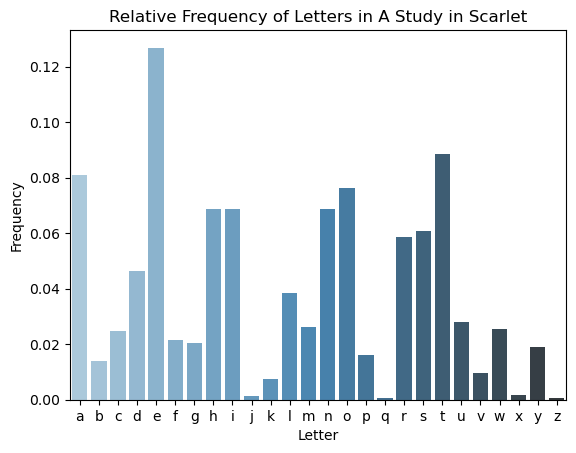

In [3]:
# Load our data into a pandas dataframe and plot the relative frequencies as a histogram that we centered on the screen.
# Let's also reformat the columns to include the letter and frequency.
%matplotlib inline
study_df = pd.DataFrame.from_dict(get_ngram_frequency_from_file('text_files/a_study_in_scarlet.txt', 1), orient='index')
study_df = study_df.reset_index()
study_df.columns = ['letter', 'frequency']
study_df = study_df.sort_values(by='letter', ascending=True)
sns.barplot(x='letter', y='frequency', data=study_df, palette='Blues_d')
plt.xlabel('Letter')
plt.ylabel('Frequency')
plt.title('Relative Frequency of Letters in A Study in Scarlet')
plt.show()

If you are wondering whether this frequency distribution is unusual, we actually cannot say either way without loading the current values of letter frequencies which we will load from the english_letter_frequencies.txt file. We will do this in the next cell once we make our .

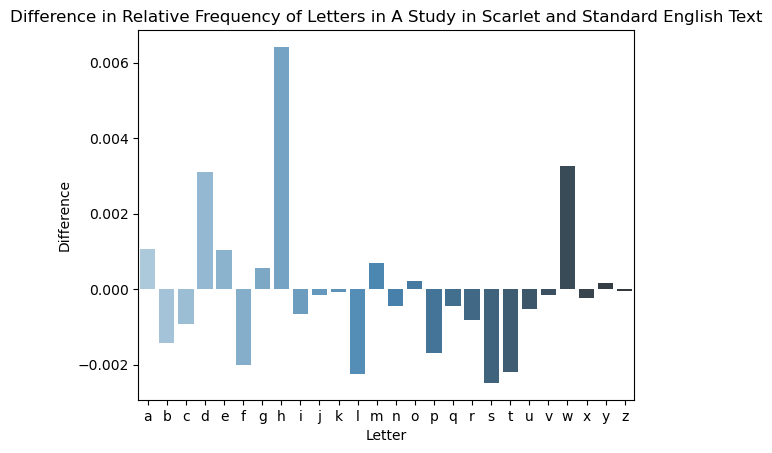

In [10]:
# Load the relative frequencies of letters in the English language into a pandas dataframe
english_df = pd.read_csv('text_tools/frequencies/english_letter_frequencies.txt', header=None)
english_df.columns = ['letter', 'frequency']

# Merge the two dataframes together and plot the relative frequencies as a histogram that we centered on the screen.
english_study_df = pd.merge(english_df, study_df, on='letter')

# Now we will add a column of the differences between the two lists of letter frequencies.
english_study_df['difference'] = english_study_df['frequency_y'] - english_study_df['frequency_x']

# Plot the differences as a histogram 
sns.barplot(x='letter', y='difference', data=english_study_df, palette='Blues_d')
plt.xlabel('Letter')
plt.ylabel('Difference')
plt.title('Difference in Relative Frequency of Letters in A Study in Scarlet and Standard English Text')
plt.show()

From this we can see that differences between the expected and actual letter frequencies in A Study in Scarlet are not too large, but they are also not so small as to be meaningless. You may be surprised by how little a difference is difference enough to be meaningful, but we will discuss this more later on when it becomes more pertinent.

Furthermore, letter frequencies are far from the only things we can look at. Let's look at the top 20 2-grams, 3-grams, and 4-grams in A Study in Scarlet and compare them to the expected frequencies.

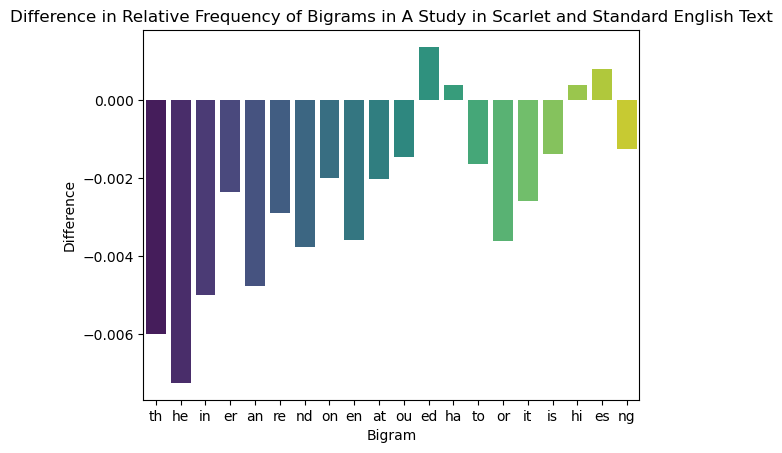

In [11]:
# Count the bigrams, tri-grams, and quad-grams in A Study in Scarlet
study_2gram_dict = get_ngram_frequency_from_file('text_files/a_study_in_scarlet.txt', 2)
study_3gram_dict = get_ngram_frequency_from_file('text_files/a_study_in_scarlet.txt', 3)
study_4gram_dict = get_ngram_frequency_from_file('text_files/a_study_in_scarlet.txt', 4)

# Add the bigrams, tri-grams, and quad-grams to dataframes and sort them by frequency
study_2gram_df = pd.DataFrame.from_dict(study_2gram_dict, orient='index')
study_2gram_df = study_2gram_df.reset_index()
study_2gram_df.columns = ['bigram', 'obs_frequency']
study_2gram_df = study_2gram_df.sort_values(by='obs_frequency', ascending=False)
study_3gram_df = pd.DataFrame.from_dict(study_3gram_dict, orient='index')
study_3gram_df = study_3gram_df.reset_index()
study_3gram_df.columns = ['trigram', 'obs_frequency']
study_3gram_df = study_3gram_df.sort_values(by='obs_frequency', ascending=False)
study_4gram_df = pd.DataFrame.from_dict(study_4gram_dict, orient='index')
study_4gram_df = study_4gram_df.reset_index()
study_4gram_df.columns = ['quadgram', 'obs_frequency']
study_4gram_df = study_4gram_df.sort_values(by='obs_frequency', ascending=False)

# Now we will load the expected frequencies of bigrams, tri-grams, and quad-grams in the English language
english_2gram_df = pd.read_csv('text_tools/frequencies/english_bigram_frequencies.txt', header=None, sep=',')
english_2gram_df.columns = ['bigram', 'ex_frequency']
english_3gram_df = pd.read_csv('text_tools/frequencies/english_trigram_frequencies.txt', header=None, sep=',')
english_3gram_df.columns = ['trigram', 'ex_frequency']
english_4gram_df = pd.read_csv('text_tools/frequencies/english_quadgram_frequencies.txt', header=None, sep=',')
english_4gram_df.columns = ['quadgram', 'ex_frequency']

# Lastly, we will merge our bigram, tri-gram, and quad-gram dataframes with the English n-gram dataframes, 
# compute the differences, and plot the differences as histograms. Let's start with the bigrams.
english_study_2gram_df = pd.merge(english_2gram_df, study_2gram_df, on='bigram')
english_study_2gram_df['difference'] = english_study_2gram_df['obs_frequency'] - english_study_2gram_df['ex_frequency']
sns.barplot(x='bigram', y='difference', data=english_study_2gram_df, palette='viridis')
plt.xlabel('Bigram')
plt.ylabel('Difference')
plt.title('Difference in Relative Frequency of Bigrams in A Study in Scarlet and Standard English Text')
plt.show()


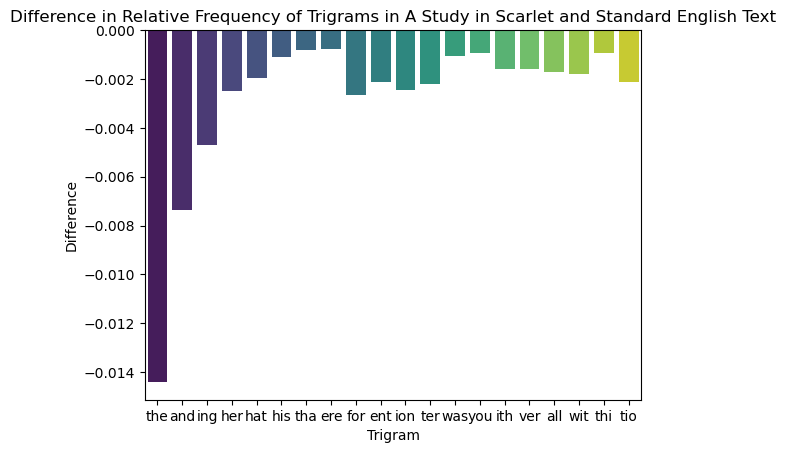

In [12]:
# Now let's do the same for the tri-grams.
english_study_3gram_df = pd.merge(english_3gram_df, study_3gram_df, on='trigram')
english_study_3gram_df['difference'] = english_study_3gram_df['obs_frequency'] - english_study_3gram_df['ex_frequency']
sns.barplot(x='trigram', y='difference', data=english_study_3gram_df, palette='viridis')
plt.xlabel('Trigram')
plt.ylabel('Difference')
plt.title('Difference in Relative Frequency of Trigrams in A Study in Scarlet and Standard English Text')
plt.show()

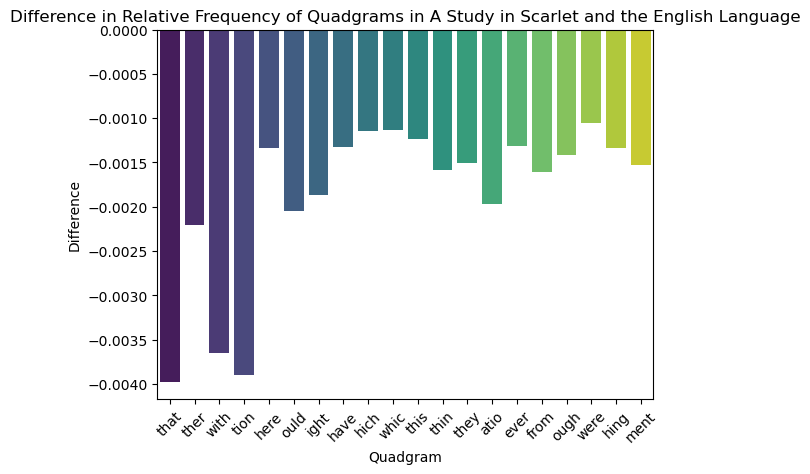

In [9]:
# Lastly, let's do the same for the quad-grams.
english_study_4gram_df = pd.merge(english_4gram_df, study_4gram_df, on='quadgram')
english_study_4gram_df['difference'] = english_study_4gram_df['obs_frequency'] - english_study_4gram_df['ex_frequency']
sns.barplot(x='quadgram', y='difference', data=english_study_4gram_df, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Quadgram')
plt.ylabel('Difference')
plt.title('Difference in Relative Frequency of Quadgrams in A Study in Scarlet and Standard English Text')
plt.show()

Before we decide whether these difference are significant (they do seem to be lower in many cases...), let's see how additional dimensionality can provide us with some interesting insights. We will calculate <i>all</i> of the bigram frequencies for A Study in Scarlet, and plot them as a heatmap. Things will get a bit more complex when we move on to trigrams and quadgrams, but we will cross that bridge when we get there.

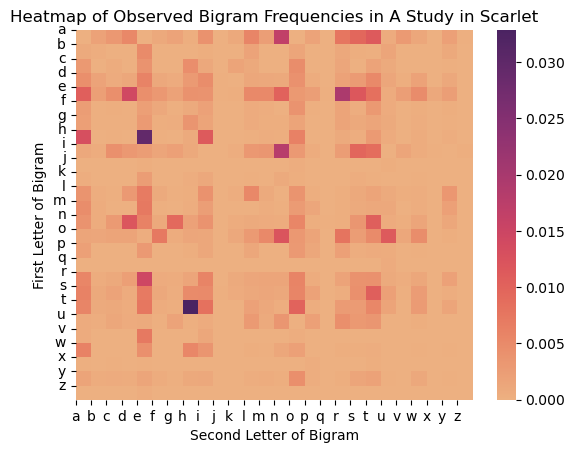

In [47]:
# Let's use the bigrams we found earlier for this.
study_2gram_df = study_2gram_df.sort_values(by='bigram', ascending=True)

# This is missing some of the possible bigrams, so we will add them in. First we will make list of strings
# containing all the possible bigrams of the English alphabet. 
alphabet = 'abcdefghijklmnopqrstuvwxyz'
bigram_list = []
for letter1 in alphabet:
    for letter2 in alphabet:
        bigram_list.append(letter1 + letter2)

# Now we will make a dataframe of all the possible bigrams and merge it with the dataframe of observed bigrams. Any missing
# bigrams from our observed bigram dataframe will have their observed frequency set to 0.
all_bigrams_df = pd.DataFrame(bigram_list)
all_bigrams_df.columns = ['bigram']
study_2gram_df = pd.merge(all_bigrams_df, study_2gram_df, on='bigram', how='right')
study_2gram_df.fillna(0, inplace=True)

# Let's look at this as a heatmap. We will first need to make a matrix of the observed frequencies
# where the rows are the first letter of the bigram and the columns are the second letter of the bigram.
import numpy as np
bigram_matrix = np.zeros((26, 26))
for i in range(26):
    for j in range(26):
        bigram_matrix[i, j] = study_2gram_df.iloc[i*26 + j, 1]

# Now we can plot the heatmap.
sns.heatmap(bigram_matrix, cmap='flare')
plt.xlabel('Second Letter of Bigram')
plt.xticks(np.arange(26), alphabet, rotation=0)
plt.ylabel('First Letter of Bigram')
plt.yticks(np.arange(26), alphabet, rotation=0)
plt.title('Heatmap of Observed Bigram Frequencies in A Study in Scarlet')
plt.show()
